## 3 Channel, CNN, Sun+Sky

In [1]:
# Math
import numpy as np
# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
from torch.optim.lr_scheduler import StepLR
# Custom
from loader import IlluminationModule, Train_Dataset, Eval_Dataset
import os
from libs.projections import bin2Sphere
from utils import getAngle

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [3]:
BATCH_SIZE = 64
EPOCHS = 500

# 하이퍼파라미터 설정
learning_rate = 0.01

In [4]:
dataset = Train_Dataset(csv_path='./mydata/trans_mode_label.csv')
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [5]:
eval_dataset = Eval_Dataset(csv_path='./mydata/trans_mode_label.csv')
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [6]:
illuminationModule = IlluminationModule().cuda()

In [7]:
from torchsummary import summary

summary(illuminationModule, input_size=(3,320,240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 160, 120]           9,472
       BatchNorm2d-2         [-1, 64, 160, 120]             128
               ELU-3         [-1, 64, 160, 120]               0
            Conv2d-4          [-1, 128, 80, 60]         204,928
       BatchNorm2d-5          [-1, 128, 80, 60]             256
               ELU-6          [-1, 128, 80, 60]               0
            Conv2d-7          [-1, 256, 40, 30]         295,168
       BatchNorm2d-8          [-1, 256, 40, 30]             512
               ELU-9          [-1, 256, 40, 30]               0
           Conv2d-10          [-1, 256, 40, 30]         590,080
      BatchNorm2d-11          [-1, 256, 40, 30]             512
              ELU-12          [-1, 256, 40, 30]               0
           Conv2d-13          [-1, 256, 20, 15]         590,080
      BatchNorm2d-14          [-1, 256,

In [8]:
sun_crit = nn.KLDivLoss()
prr_crit = nn.MSELoss()
# set optimizer
optimizer = optim.Adam(illuminationModule.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1,)

In [9]:
def trainloop(module, lr=0.01, train_epochs=EPOCHS):
    global total_l, sky_l, sun_l
    # set training dataset
    dataset = Train_Dataset(csv_path='./mydata/trans_mode_label.csv')
    train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

    # using KL divergence loss for sun distribution and MSE loss  
    sun_crit = nn.KLDivLoss()
    prr_crit = nn.MSELoss()
    # set optimizer
    optimizer = torch.optim.Adam(module.parameters(), lr=lr)

    # train the model
    cur_lr = lr

    for i in range(train_epochs):
        module.train()
        for i_batch, sample in enumerate(train_dataloader):
            # training input and targets
            img = sample['img'].cuda().float()
            label_dis, label_prrs = sample['dis'].cuda().float(), sample['prrs'].cuda().float()

            # forward pass 
            pred_dis, pred_prrs = module(img)
            beta = 0.1 # to compensate for the number od bins in output distribution
            sun_loss, prr_loss = sun_crit(pred_dis, label_dis), prr_crit(pred_prrs, label_prrs)
            loss = sun_loss + beta * prr_loss

            # optimization
            #if i_batch % 10 == 0 :
                #print('epoch:', i+1, 'steps:', i_batch+1, "sun_loss: ", 'loss:', loss.item())
            #    print('EPOCH : %d, STEPS : %d, sun_loss : %.5f, prr_loss : %.5f, loss : %.5f'%(i+1, i_batch+1, sun_loss.item(), prr_loss.item(), loss.item()))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_l.append(loss.item())
        sun_l.append(sun_loss.item())
        sky_l.append(prr_loss.item())
        
        print('='*20,'EPOCH : ', i,'='*20)
        print('-'*20,'TRAIN','-'*20)
        print("sun_loss : {:.5f},  prr_loss : {:.5f},  loss : {:.5f} ".format(sun_loss.item(), prr_loss.item(), loss.item()))
        print('-'*20,'TEST','-'*20)
        evaluate(module, eval_dataloader, optimizer, train_epochs)
        
        # Decay learning rate (0.5/15 epochs)
        if i % 15 == 0:
            cur_lr *= 0.5
            update_lr(optimizer, cur_lr)
        

    # Save the model checkpoint
    torch.save(module.state_dict(), '17_9_weights.pth')

In [10]:
test_total_l = []
test_sun_l = []
test_sky_l = []


def evaluate(module, eval_dataloader, optimizer, epoch):
    module.eval()
    
    sum_err = np.asarray([0, 0, 0, 0, 0, 0]).astype('float64')
    sum_loss = 0.0
    data_length = len(eval_dataloader)
    suns=[]
    suns_gt=[]
    bins=[]
    angular=[]
    
    for i, sample in enumerate(eval_dataloader):
        num_of_mini_batch = len(eval_dataloader)
        input_img = sample['img'].cuda().float()
        label_dis, label_prrs = sample['dis'].cuda().float(), sample['prrs'].cuda().float()
        sunpos = sample['sp'][0].numpy()

        with torch.no_grad():
            #print("="*20,i,"="*20)
            pred_dis, pred_prrs = module(input_img)
            #print("pred_dis  shape : ", pred_dis.shape) # (1, 256)
            #print("pred_dis : ", pred_dis)
            #print("pred_prrs : ", pred_prrs)
            #print(input_img)
            sun_loss, prr_loss = sun_crit(pred_dis, label_dis), prr_crit(pred_prrs, label_prrs)
            beta = 0.1
            loss = sun_loss + beta * prr_loss

            sum_loss += loss.item()
#                print("sum_loss : " , sum_loss)

            # calculate all prediction error
            bins.append(np.argmax(pred_dis.cpu().numpy()[0]))
            pred_sunpos = bin2Sphere(np.argmax(pred_dis.cpu().numpy()[0])) # predicted sun position is the bin with highest probability
            #print('pred_sunpos : ', pred_sunpos)
            suns.append(pred_sunpos)
            suns_gt.append(sunpos)
            sunpos_err = getAngle(sunpos, pred_sunpos)
#                print(sunpos)
#                print(pred_sunpos)
            angular.append(sunpos_err)
            # Sky sun kappa beta turbidity
            sky_err = abs(pred_prrs.cpu().numpy()[0][0] - label_prrs.cpu().numpy()[0][0]) + abs(pred_prrs.cpu().numpy()[0][1] - label_prrs.cpu().numpy()[0][1]) + abs(pred_prrs.cpu().numpy()[0][2] - label_prrs.cpu().numpy()[0][2])
            sun_color_err = abs(pred_prrs.cpu().numpy()[0][3] - label_prrs.cpu().numpy()[0][3]) + abs(pred_prrs.cpu().numpy()[0][4] - label_prrs.cpu().numpy()[0][4]) + abs(pred_prrs.cpu().numpy()[0][5] - label_prrs.cpu().numpy()[0][5])
            kappa_err = abs(pred_prrs.cpu().numpy()[0][6] - label_prrs.cpu().numpy()[0][6])
            beta_err = abs(pred_prrs.cpu().numpy()[0][7] - label_prrs.cpu().numpy()[0][7])
            tur_err = abs(pred_prrs.cpu().numpy()[0][8] - label_prrs.cpu().numpy()[0][8])
            sum_err += np.asarray([sunpos_err, sky_err, sun_color_err, kappa_err, beta_err, tur_err])

#            if i % 5 == 0:
#                print("({:.0f}%)   sun_loss : {:.5f},  prr_loss : {:.5f},  loss : {:.5f} ".format(100.*i / num_of_mini_batch, sun_loss.item(), prr_loss.item(), loss.item()))

    print("sun_loss : {:.5f},  prr_loss : {:.5f},  loss : {:.5f} ".format(sun_loss.item(), prr_loss.item(), loss.item()))
    if epoch == 499:    
        print("="*20,"FINAL ERROR","="*20)
    #    print('Testing avg loss:', sum_loss/data_length)
        final_err = sum_err/data_length
    #    print('Average predictions error:')
        print('sun position (angular error):', final_err[0])
        print('sky color error :', final_err[1])
        print('sun color error:', final_err[2])
        print('kappa error :', final_err[3])
        print('beta error:', final_err[4])
        print('turbidity error:', final_err[5])

    test_total_l.append(loss.item())
    test_sun_l.append(sun_loss.item())
    test_sky_l.append(prr_loss.item())
    return suns_gt, suns, bins, angular

In [11]:
def main():

    # device configuration
    torch.cuda.set_device(0)
    # get network module 
    Module = IlluminationModule().cuda()

    trainloop(Module)
    
total_l = []
sun_l = []
sky_l = []

if __name__ == '__main__':
    main()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


==================== EPOCH :  0 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01379,  prr_loss : 67.07406,  loss : 6.72119 
-------------------- TEST --------------------
sun_loss : 0.03068,  prr_loss : 85.91568,  loss : 8.62225 
==================== EPOCH :  1 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01333,  prr_loss : 59.91687,  loss : 6.00502 
-------------------- TEST --------------------
sun_loss : 0.01453,  prr_loss : 58.78709,  loss : 5.89324 
==================== EPOCH :  2 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01384,  prr_loss : 71.13066,  loss : 7.12691 
-------------------- TEST --------------------
sun_loss : 0.01394,  prr_loss : 57.38984,  loss : 5.75292 
==================== EPOCH :  3 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01327,  prr_loss : 70.59446,  loss : 7.07271 
-------------------- TEST ----------------

sun_loss : 0.01099,  prr_loss : 44.78302,  loss : 4.48929 
==================== EPOCH :  31 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01085,  prr_loss : 53.22411,  loss : 5.33326 
-------------------- TEST --------------------
sun_loss : 0.01098,  prr_loss : 48.43786,  loss : 4.85476 
==================== EPOCH :  32 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01046,  prr_loss : 44.68492,  loss : 4.47895 
-------------------- TEST --------------------
sun_loss : 0.01114,  prr_loss : 45.73434,  loss : 4.58457 
==================== EPOCH :  33 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01056,  prr_loss : 46.46756,  loss : 4.65732 
-------------------- TEST --------------------
sun_loss : 0.01093,  prr_loss : 47.31065,  loss : 4.74200 
==================== EPOCH :  34 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01052,  prr_loss : 56.591

sun_loss : 0.01080,  prr_loss : 43.70570,  loss : 4.38137 
==================== EPOCH :  62 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01002,  prr_loss : 37.55872,  loss : 3.76589 
-------------------- TEST --------------------
sun_loss : 0.01090,  prr_loss : 43.38011,  loss : 4.34891 
==================== EPOCH :  63 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00887,  prr_loss : 54.95572,  loss : 5.50444 
-------------------- TEST --------------------
sun_loss : 0.01085,  prr_loss : 43.08629,  loss : 4.31948 
==================== EPOCH :  64 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00925,  prr_loss : 53.78254,  loss : 5.38751 
-------------------- TEST --------------------
sun_loss : 0.01086,  prr_loss : 44.23137,  loss : 4.43400 
==================== EPOCH :  65 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00879,  prr_loss : 51.762

sun_loss : 0.01081,  prr_loss : 42.85118,  loss : 4.29593 
==================== EPOCH :  93 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00910,  prr_loss : 42.84464,  loss : 4.29356 
-------------------- TEST --------------------
sun_loss : 0.01087,  prr_loss : 42.38844,  loss : 4.24971 
==================== EPOCH :  94 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00963,  prr_loss : 49.94126,  loss : 5.00376 
-------------------- TEST --------------------
sun_loss : 0.01085,  prr_loss : 42.93395,  loss : 4.30424 
==================== EPOCH :  95 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00838,  prr_loss : 40.65002,  loss : 4.07338 
-------------------- TEST --------------------
sun_loss : 0.01084,  prr_loss : 42.80746,  loss : 4.29158 
==================== EPOCH :  96 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00912,  prr_loss : 46.427

sun_loss : 0.01088,  prr_loss : 42.50410,  loss : 4.26129 
==================== EPOCH :  124 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00909,  prr_loss : 47.36972,  loss : 4.74606 
-------------------- TEST --------------------
sun_loss : 0.01083,  prr_loss : 42.54919,  loss : 4.26575 
==================== EPOCH :  125 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00912,  prr_loss : 41.23946,  loss : 4.13306 
-------------------- TEST --------------------
sun_loss : 0.01084,  prr_loss : 42.56057,  loss : 4.26690 
==================== EPOCH :  126 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00888,  prr_loss : 42.51524,  loss : 4.26040 
-------------------- TEST --------------------
sun_loss : 0.01085,  prr_loss : 42.61729,  loss : 4.27258 
==================== EPOCH :  127 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00958,  prr_loss : 43

sun_loss : 0.01086,  prr_loss : 42.46989,  loss : 4.25785 
==================== EPOCH :  155 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00850,  prr_loss : 38.89025,  loss : 3.89753 
-------------------- TEST --------------------
sun_loss : 0.01087,  prr_loss : 42.34487,  loss : 4.24535 
==================== EPOCH :  156 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00933,  prr_loss : 53.58273,  loss : 5.36760 
-------------------- TEST --------------------
sun_loss : 0.01085,  prr_loss : 42.48625,  loss : 4.25948 
==================== EPOCH :  157 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00811,  prr_loss : 43.24501,  loss : 4.33261 
-------------------- TEST --------------------
sun_loss : 0.01087,  prr_loss : 42.46495,  loss : 4.25736 
==================== EPOCH :  158 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00913,  prr_loss : 47

sun_loss : 0.01085,  prr_loss : 42.47444,  loss : 4.25829 
==================== EPOCH :  186 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00936,  prr_loss : 48.25853,  loss : 4.83521 
-------------------- TEST --------------------
sun_loss : 0.01088,  prr_loss : 42.50675,  loss : 4.26156 
==================== EPOCH :  187 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00888,  prr_loss : 46.94605,  loss : 4.70349 
-------------------- TEST --------------------
sun_loss : 0.01085,  prr_loss : 42.41274,  loss : 4.25213 
==================== EPOCH :  188 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00884,  prr_loss : 43.74540,  loss : 4.38338 
-------------------- TEST --------------------
sun_loss : 0.01087,  prr_loss : 42.53544,  loss : 4.26441 
==================== EPOCH :  189 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00842,  prr_loss : 44

sun_loss : 0.01086,  prr_loss : 42.57722,  loss : 4.26858 
==================== EPOCH :  217 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00933,  prr_loss : 47.19765,  loss : 4.72909 
-------------------- TEST --------------------
sun_loss : 0.01084,  prr_loss : 42.53956,  loss : 4.26480 
==================== EPOCH :  218 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00908,  prr_loss : 48.73859,  loss : 4.88294 
-------------------- TEST --------------------
sun_loss : 0.01085,  prr_loss : 42.52110,  loss : 4.26296 
==================== EPOCH :  219 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00942,  prr_loss : 41.46215,  loss : 4.15564 
-------------------- TEST --------------------
sun_loss : 0.01085,  prr_loss : 42.44335,  loss : 4.25519 
==================== EPOCH :  220 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00913,  prr_loss : 41

sun_loss : 0.01083,  prr_loss : 42.62439,  loss : 4.27327 
==================== EPOCH :  248 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00956,  prr_loss : 43.52161,  loss : 4.36172 
-------------------- TEST --------------------
sun_loss : 0.01084,  prr_loss : 42.53841,  loss : 4.26468 
==================== EPOCH :  249 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00916,  prr_loss : 45.45961,  loss : 4.55512 
-------------------- TEST --------------------
sun_loss : 0.01084,  prr_loss : 42.53775,  loss : 4.26461 
==================== EPOCH :  250 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00913,  prr_loss : 40.87469,  loss : 4.09660 
-------------------- TEST --------------------
sun_loss : 0.01087,  prr_loss : 42.35825,  loss : 4.24669 
==================== EPOCH :  251 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00878,  prr_loss : 44

sun_loss : 0.01083,  prr_loss : 42.61993,  loss : 4.27283 
==================== EPOCH :  279 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00872,  prr_loss : 43.89049,  loss : 4.39777 
-------------------- TEST --------------------
sun_loss : 0.01083,  prr_loss : 42.54019,  loss : 4.26484 
==================== EPOCH :  280 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00879,  prr_loss : 50.63863,  loss : 5.07266 
-------------------- TEST --------------------
sun_loss : 0.01083,  prr_loss : 42.51476,  loss : 4.26231 
==================== EPOCH :  281 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00896,  prr_loss : 46.75734,  loss : 4.68469 
-------------------- TEST --------------------
sun_loss : 0.01080,  prr_loss : 42.50396,  loss : 4.26120 
==================== EPOCH :  282 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00861,  prr_loss : 36

sun_loss : 0.01083,  prr_loss : 42.71274,  loss : 4.28210 
==================== EPOCH :  310 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00915,  prr_loss : 42.22463,  loss : 4.23161 
-------------------- TEST --------------------
sun_loss : 0.01084,  prr_loss : 42.48067,  loss : 4.25891 
==================== EPOCH :  311 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00948,  prr_loss : 48.97205,  loss : 4.90668 
-------------------- TEST --------------------
sun_loss : 0.01084,  prr_loss : 42.60259,  loss : 4.27109 
==================== EPOCH :  312 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00845,  prr_loss : 54.32718,  loss : 5.44117 
-------------------- TEST --------------------
sun_loss : 0.01086,  prr_loss : 42.58873,  loss : 4.26974 
==================== EPOCH :  313 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00932,  prr_loss : 53

sun_loss : 0.01084,  prr_loss : 42.58099,  loss : 4.26894 
==================== EPOCH :  341 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00915,  prr_loss : 43.78812,  loss : 4.38797 
-------------------- TEST --------------------
sun_loss : 0.01086,  prr_loss : 42.36294,  loss : 4.24715 
==================== EPOCH :  342 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00904,  prr_loss : 43.36633,  loss : 4.34567 
-------------------- TEST --------------------
sun_loss : 0.01084,  prr_loss : 42.69717,  loss : 4.28056 
==================== EPOCH :  343 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00919,  prr_loss : 43.90536,  loss : 4.39972 
-------------------- TEST --------------------
sun_loss : 0.01084,  prr_loss : 42.64638,  loss : 4.27548 
==================== EPOCH :  344 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00871,  prr_loss : 49

sun_loss : 0.01086,  prr_loss : 42.85771,  loss : 4.29663 
==================== EPOCH :  372 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00854,  prr_loss : 45.09335,  loss : 4.51787 
-------------------- TEST --------------------
sun_loss : 0.01086,  prr_loss : 42.60452,  loss : 4.27131 
==================== EPOCH :  373 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00972,  prr_loss : 47.04508,  loss : 4.71423 
-------------------- TEST --------------------
sun_loss : 0.01085,  prr_loss : 42.47028,  loss : 4.25788 
==================== EPOCH :  374 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00941,  prr_loss : 39.82974,  loss : 3.99239 
-------------------- TEST --------------------
sun_loss : 0.01086,  prr_loss : 42.21039,  loss : 4.23190 
==================== EPOCH :  375 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00979,  prr_loss : 41

sun_loss : 0.01088,  prr_loss : 42.58232,  loss : 4.26912 
==================== EPOCH :  403 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00898,  prr_loss : 40.97041,  loss : 4.10602 
-------------------- TEST --------------------
sun_loss : 0.01088,  prr_loss : 42.50436,  loss : 4.26131 
==================== EPOCH :  404 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00894,  prr_loss : 47.90318,  loss : 4.79926 
-------------------- TEST --------------------
sun_loss : 0.01088,  prr_loss : 42.45834,  loss : 4.25672 
==================== EPOCH :  405 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00880,  prr_loss : 43.95875,  loss : 4.40468 
-------------------- TEST --------------------
sun_loss : 0.01088,  prr_loss : 42.52193,  loss : 4.26307 
==================== EPOCH :  406 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00954,  prr_loss : 51

sun_loss : 0.01083,  prr_loss : 42.70918,  loss : 4.28175 
==================== EPOCH :  434 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00902,  prr_loss : 36.34043,  loss : 3.64307 
-------------------- TEST --------------------
sun_loss : 0.01082,  prr_loss : 42.40969,  loss : 4.25179 
==================== EPOCH :  435 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00998,  prr_loss : 40.89246,  loss : 4.09923 
-------------------- TEST --------------------
sun_loss : 0.01086,  prr_loss : 42.25736,  loss : 4.23659 
==================== EPOCH :  436 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00904,  prr_loss : 47.70054,  loss : 4.77909 
-------------------- TEST --------------------
sun_loss : 0.01085,  prr_loss : 42.54949,  loss : 4.26580 
==================== EPOCH :  437 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00906,  prr_loss : 44

sun_loss : 0.01083,  prr_loss : 42.57551,  loss : 4.26838 
==================== EPOCH :  465 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00996,  prr_loss : 47.01734,  loss : 4.71170 
-------------------- TEST --------------------
sun_loss : 0.01085,  prr_loss : 42.68053,  loss : 4.27890 
==================== EPOCH :  466 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00989,  prr_loss : 42.57337,  loss : 4.26723 
-------------------- TEST --------------------
sun_loss : 0.01088,  prr_loss : 42.46091,  loss : 4.25697 
==================== EPOCH :  467 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00899,  prr_loss : 44.20809,  loss : 4.42980 
-------------------- TEST --------------------
sun_loss : 0.01083,  prr_loss : 42.74140,  loss : 4.28497 
==================== EPOCH :  468 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00856,  prr_loss : 45

sun_loss : 0.01084,  prr_loss : 42.63451,  loss : 4.27429 
==================== EPOCH :  496 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00948,  prr_loss : 42.26446,  loss : 4.23593 
-------------------- TEST --------------------
sun_loss : 0.01091,  prr_loss : 42.54094,  loss : 4.26500 
==================== EPOCH :  497 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00939,  prr_loss : 42.10762,  loss : 4.22015 
-------------------- TEST --------------------
sun_loss : 0.01087,  prr_loss : 42.41924,  loss : 4.25279 
==================== EPOCH :  498 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00909,  prr_loss : 41.80948,  loss : 4.19004 
-------------------- TEST --------------------
sun_loss : 0.01086,  prr_loss : 42.33897,  loss : 4.24476 
==================== EPOCH :  499 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00887,  prr_loss : 42

In [12]:
print(total_l)

[6.721193790435791, 6.005020618438721, 7.12691068649292, 7.072714328765869, 6.427473545074463, 6.203980445861816, 5.93482780456543, 7.360199928283691, 6.980077743530273, 6.451284408569336, 4.959564208984375, 5.679518222808838, 6.02427339553833, 5.815298557281494, 5.954542636871338, 5.387953281402588, 4.2440595626831055, 5.630509853363037, 5.748839378356934, 5.0492963790893555, 6.001668930053711, 4.855697154998779, 5.6179890632629395, 5.565859794616699, 5.356098651885986, 5.162846088409424, 5.139637470245361, 4.8972554206848145, 4.429260730743408, 4.341643333435059, 3.980037212371826, 5.3332600593566895, 4.478950500488281, 4.657317161560059, 5.669658184051514, 5.019488334655762, 4.921651840209961, 4.632896423339844, 4.837413311004639, 5.213781833648682, 5.8117241859436035, 4.319327354431152, 4.901495456695557, 4.549797058105469, 5.169595718383789, 5.458055019378662, 4.472720146179199, 4.281979560852051, 5.962460517883301, 4.980021953582764, 5.626068592071533, 4.14326810836792, 4.0167093

In [13]:
print(sky_l)

[67.07405853271484, 59.9168701171875, 71.13066101074219, 70.5944595336914, 64.14962005615234, 61.91578674316406, 59.22407531738281, 73.48448181152344, 69.68395233154297, 64.39195251464844, 49.47677993774414, 56.67123794555664, 60.12594985961914, 58.03658676147461, 59.42963790893555, 53.75876998901367, 42.32275390625, 56.1905517578125, 57.380733489990234, 50.375732421875, 59.90253448486328, 48.44540786743164, 56.06859588623047, 55.55278015136719, 53.4543342590332, 51.52322769165039, 51.28882598876953, 48.87028884887695, 44.185386657714844, 43.29844284057617, 39.68861389160156, 53.2241096496582, 44.68491744995117, 46.46756362915039, 56.591400146484375, 50.08938980102539, 49.11347961425781, 46.22946548461914, 48.279964447021484, 52.04042434692383, 58.01310729980469, 43.093204498291016, 48.9132080078125, 45.405147552490234, 51.60037612915039, 54.480045318603516, 44.620643615722656, 42.72072219848633, 59.523983001708984, 49.70018768310547, 56.163944244384766, 41.33999252319336, 40.076301574

In [14]:
print(sun_l)

[0.013787569478154182, 0.013333083130419254, 0.013844350352883339, 0.013268237002193928, 0.012511062435805798, 0.012401510961353779, 0.0124199902638793, 0.011751506477594376, 0.011682580225169659, 0.012089172378182411, 0.011886101216077805, 0.012394336983561516, 0.011678344570100307, 0.011639457195997238, 0.01157859805971384, 0.012076608836650848, 0.011784150265157223, 0.011454536579549313, 0.010766078718006611, 0.011722903698682785, 0.011415403336286545, 0.011156303808093071, 0.011129336431622505, 0.010581267066299915, 0.010664703324437141, 0.010523241944611073, 0.010754349641501904, 0.010226350277662277, 0.01072232611477375, 0.011798654682934284, 0.011175768449902534, 0.01084918063133955, 0.010458472184836864, 0.010560303926467896, 0.010518135502934456, 0.010549265891313553, 0.010303955525159836, 0.009949486702680588, 0.0094165513291955, 0.009739606641232967, 0.010413297452032566, 0.010006863623857498, 0.010174814611673355, 0.009281936101615429, 0.009558020159602165, 0.01005047652870

In [15]:
print(test_total_l)

[8.622245788574219, 5.893237113952637, 5.752922058105469, 5.600653171539307, 5.55551290512085, 5.455714225769043, 5.304330348968506, 5.380248546600342, 5.31922721862793, 5.641758918762207, 4.974678993225098, 5.3534932136535645, 5.376631736755371, 4.670445919036865, 5.223385334014893, 5.107654094696045, 4.818516254425049, 5.084982395172119, 4.961557388305664, 5.046823978424072, 4.943560600280762, 4.717740058898926, 4.93491268157959, 4.721170425415039, 4.544556617736816, 4.88905668258667, 4.716748237609863, 4.767574310302734, 4.7145094871521, 4.700916290283203, 4.489291191101074, 4.854763507843018, 4.5845723152160645, 4.741997718811035, 4.545455455780029, 4.638175964355469, 4.485168933868408, 4.587335586547852, 4.4918599128723145, 4.512172222137451, 4.392458915710449, 4.5114264488220215, 4.4947285652160645, 4.582357883453369, 4.391485214233398, 4.540798664093018, 4.542471885681152, 4.506906986236572, 4.48878812789917, 4.381053447723389, 4.492824077606201, 4.4342427253723145, 4.4610185623

In [16]:
print(test_sky_l)

[85.91567993164062, 58.78709411621094, 57.389835357666016, 55.865928649902344, 55.42591094970703, 54.431278228759766, 52.91651916503906, 53.676639556884766, 53.070068359375, 56.29896926879883, 49.619651794433594, 53.41980743408203, 53.65078353881836, 46.58219528198242, 52.12055206298828, 50.96058654785156, 48.069942474365234, 50.735660552978516, 49.50393295288086, 50.35659408569336, 49.32312774658203, 47.06395721435547, 49.23934555053711, 47.10228729248047, 45.33406448364258, 48.779998779296875, 47.05751419067383, 47.565879821777344, 47.034385681152344, 46.895668029785156, 44.78302001953125, 48.437862396240234, 45.73434066772461, 47.310646057128906, 45.34326934814453, 46.272796630859375, 44.74063491821289, 45.76316452026367, 44.80839538574219, 45.012943267822266, 43.815208435058594, 45.004188537597656, 44.835941314697266, 45.715431213378906, 43.80439376831055, 45.29985427856445, 45.314571380615234, 44.9599494934082, 44.7799072265625, 43.70224380493164, 44.82018280029297, 44.23366928100

In [17]:
print(test_sun_l)

[0.030678143724799156, 0.014527854509651661, 0.013938340358436108, 0.014059881679713726, 0.012921842746436596, 0.012585917487740517, 0.012678204104304314, 0.012584822252392769, 0.012220257893204689, 0.011861762031912804, 0.012713720090687275, 0.011512363329529762, 0.011553062126040459, 0.012226325459778309, 0.011330158449709415, 0.011595318093895912, 0.011522017419338226, 0.011416501365602016, 0.011164209805428982, 0.01116477232426405, 0.01124751940369606, 0.011344466358423233, 0.01097829919308424, 0.01094132848083973, 0.011150000616908073, 0.01105666533112526, 0.010996676050126553, 0.010986510664224625, 0.0110707962885499, 0.011349314823746681, 0.010989068076014519, 0.01097719743847847, 0.011137819848954678, 0.01093295868486166, 0.011128638871014118, 0.01089610904455185, 0.011105366051197052, 0.011019006371498108, 0.011020142585039139, 0.010877701453864574, 0.010938149876892567, 0.011007082648575306, 0.011133928783237934, 0.010814634151756763, 0.011045776307582855, 0.01081343553960323

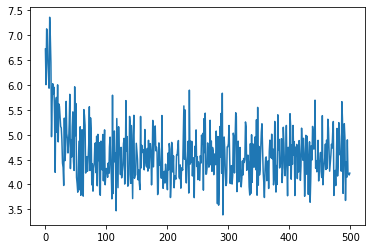

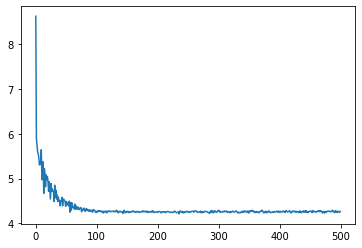

In [19]:
import matplotlib.pyplot as plt
plt.plot(total_l)
plt.show()

plt.plot(test_total_l)
plt.show()

In [4]:
import argparse
import progressbar
def evaluate(module):
    # loss function
    sun_crit = nn.KLDivLoss()
    prr_crit = nn.MSELoss()

    # data loader
    eval_dataset = Eval_Dataset(csv_path='./mydata/trans_mode_label.csv')
    eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False, num_workers=4)
    print(eval_dataloader)

    module.eval()
    
    sum_err = np.asarray([0, 0, 0, 0, 0, 0]).astype('float64')
    sum_loss = 0.0
    data_length = len(eval_dataloader)
    suns=[]
    suns_gt=[]
    bins=[]
    angular=[]
    with progressbar.ProgressBar(max_value=data_length) as bar:
        for i, sample in enumerate(eval_dataloader):
            input_img = sample['img'].cuda().float()
            label_dis, label_prrs = sample['dis'].cuda().float(), sample['prrs'].cuda().float()
            sunpos = sample['sp'][0].numpy()

            with torch.no_grad():
                #print("="*20,i,"="*20)
                pred_dis, pred_prrs = module(input_img)
                #print("pred_dis  shape : ", pred_dis.shape) # (1, 256)
                #print("pred_dis : ", pred_dis)
                #print("pred_prrs : ", pred_prrs)
                #print(input_img)
                sun_loss, prr_loss = sun_crit(pred_dis, label_dis), prr_crit(pred_prrs, label_prrs)
                beta = 0.1
                loss = sun_loss + beta * prr_loss
                sum_loss += loss.item()
                
                # calculate all prediction error
                bins.append(np.argmax(pred_dis.cpu().numpy()[0]))
                pred_sunpos = bin2Sphere(np.argmax(pred_dis.cpu().numpy()[0])) # predicted sun position is the bin with highest probability
                #print('pred_sunpos : ', pred_sunpos)
                suns.append(pred_sunpos)
                suns_gt.append(sunpos)
                sunpos_err = getAngle(sunpos, pred_sunpos)
#                print(sunpos)
#                print(pred_sunpos)
                angular.append(sunpos_err)
                # Sky sun kappa beta turbidity
                sky_err = abs(pred_prrs.cpu().numpy()[0][0] - label_prrs.cpu().numpy()[0][0]) + abs(pred_prrs.cpu().numpy()[0][1] - label_prrs.cpu().numpy()[0][1]) + abs(pred_prrs.cpu().numpy()[0][2] - label_prrs.cpu().numpy()[0][2])
                sun_color_err = abs(pred_prrs.cpu().numpy()[0][3] - label_prrs.cpu().numpy()[0][3]) + abs(pred_prrs.cpu().numpy()[0][4] - label_prrs.cpu().numpy()[0][4]) + abs(pred_prrs.cpu().numpy()[0][5] - label_prrs.cpu().numpy()[0][5])
                kappa_err = abs(pred_prrs.cpu().numpy()[0][6] - label_prrs.cpu().numpy()[0][6])
                beta_err = abs(pred_prrs.cpu().numpy()[0][7] - label_prrs.cpu().numpy()[0][7])
                tur_err = abs(pred_prrs.cpu().numpy()[0][8] - label_prrs.cpu().numpy()[0][8])
                sum_err += np.asarray([sunpos_err, sky_err, sun_color_err, kappa_err, beta_err, tur_err])
            bar.update(i)
    # print average prediction errors across all testing dataset
    print("="*20,"FINAL ERROR","="*20)
    print('Testing avg loss:', sum_loss/data_length)
    final_err = sum_err/data_length
    print('Average predictions error:')
    print('sun position (angular error):', final_err[0])
    print('sky color error :', final_err[1])
    print('sun color error:', final_err[2])
    print('kappa error :', final_err[3])
    print('beta error:', final_err[4])
    print('turbidity error:', final_err[5])
    return suns_gt, suns, bins, angular

In [5]:
def main(args):
    print('loading weights ...')
    # device configuration
    torch.cuda.set_device(0)
    # get network module 
    module = IlluminationModule().cuda()
    #load pre-trained weight
    module.load_state_dict(torch.load(args.pre_trained))

    print('start evaluating ...')
    suns_gt, suns, bins, angular= evaluate(module)
    print('evaluation done!')
    return suns_gt, suns, bins, angular

In [6]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
  
    parser.add_argument('--pre_trained', default='./17_9_weights.pth', help='pre-trained weight path')
    
    args = parser.parse_args(args=[])
    
    suns_gt, suns, bins, angular = main(args)

loading weights ...
start evaluating ...


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
100% (446 of 446) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


==================== FINAL ERROR ====================
Testing avg loss: 4.712068756599598
Average predictions error:
sun position (angular error): 51.493291885514715
sky color error : 0.20107795745802567
sun color error: 1.3942882417609306
kappa error : 0.06607706760444716
beta error: 9.532469208465029
turbidity error: 16.382776779978798
evaluation done!


In [7]:
print(angular)

[1.860115456708389, 13.99351667215026, 41.80221380949034, 41.80221380949034, 27.816414482577017, 103.65458294968248, 14.827237538351255, 80.50424714863048, 124.20063066716367, 49.04819033611861, 49.04819033611861, 85.464586383137, 85.464586383137, 85.464586383137, 123.85382212859174, 22.248234660989677, 22.075720555160114, 133.85403070290545, 57.058629007684644, 105.59326027281486, 110.83076797955293, 84.3873563561804, 31.606666779075017, 73.87437096909579, 64.58601435801779, 14.446360857073033, 25.903894206691543, 12.620146089925553, 12.620146089925553, 12.620146089925553, 42.764370886026335, 7.854466005317228, 7.854466005317228, 2.545339845064745, 31.69725010265986, 1.768955336561102, 96.2482616021199, 123.9142174777166, 92.01274448600547, 27.080251782235724, 98.09923708313627, 36.579787465075235, 27.080251782235724, 12.917871560337359, 16.04316879885059, 7.098181373435189, 7.098181373435189, 5.0153327655385445, 5.0153327655385445, 12.191935186909365, 101.57256636886369, 97.221706499

In [4]:
sorted([1.860115456708389, 13.99351667215026, 41.80221380949034, 41.80221380949034, 27.816414482577017, 103.65458294968248, 14.827237538351255, 80.50424714863048, 124.20063066716367, 49.04819033611861, 49.04819033611861, 85.464586383137, 85.464586383137, 85.464586383137, 123.85382212859174, 22.248234660989677, 22.075720555160114, 133.85403070290545, 57.058629007684644, 105.59326027281486, 110.83076797955293, 84.3873563561804, 31.606666779075017, 73.87437096909579, 64.58601435801779, 14.446360857073033, 25.903894206691543, 12.620146089925553, 12.620146089925553, 12.620146089925553, 42.764370886026335, 7.854466005317228, 7.854466005317228, 2.545339845064745, 31.69725010265986, 1.768955336561102, 96.2482616021199, 123.9142174777166, 92.01274448600547, 27.080251782235724, 98.09923708313627, 36.579787465075235, 27.080251782235724, 12.917871560337359, 16.04316879885059, 7.098181373435189, 7.098181373435189, 5.0153327655385445, 5.0153327655385445, 12.191935186909365, 101.57256636886369, 97.22170649912024, 88.40497400664582, 117.0875736792298, 75.43120528247128, 117.0875736792298, 102.28274267044898, 102.28274267044898, 37.135501311262246, 56.15829012093495, 35.73208450846668, 27.729954795766282, 102.13812159948682, 102.13812159948682, 103.58325504834605, 63.94988467489214, 9.75352432932105, 43.90760193524305, 115.59593156710753, 81.92267797362639, 43.90760193524305, 129.2854091528526, 6.919639867140062, 30.190155522291825, 55.2283525503794, 21.200625455957663, 5.633951487252932, 69.976518293974, 5.633956636762438, 41.82515518144518, 27.53870010934199, 34.11729670222522, 12.534658018267073, 105.06855083183353, 28.1796757479663, 80.17628449432803, 23.21472321662497, 101.58362636250178, 34.06108350926968, 111.89443506368434, 2.889421466869958, 9.641871584784095, 2.889421466869958, 60.83359448921561, 48.61785070249506, 26.471528622277685, 88.13128451105857, 84.65455014343128, 101.87932708074796, 5.262868377519556, 5.262868377519556, 62.356653158583285, 9.735520246198776, 65.12752897820208, 101.70555706389956, 92.10641900496154, 92.10641900496154, 72.71844377333645, 22.50141640849954, 79.4610907364031, 31.474230883332993, 22.457350840460915, 54.10292764181221, 83.84225630039674, 71.7124063224404, 83.50892090291991, 65.96085620477317, 114.62507387255346, 64.70221756640184, 47.35609594736805, 29.10123786463519, 34.46751866821221, 72.89907721717042, 80.68894220438891, 1.183306842144129, 42.012825942205716, 6.565178532005936, 55.465422967809175, 30.07120413189637, 55.465422967809175, 28.00565881554099, 30.70917988744477, 28.67891497235716, 9.205136917919274, 9.205136917919274, 2.882298384440676, 5.008476259323235, 7.971719982181598, 1.5822594521452553, 10.875462941972625, 36.55888279714459, 30.209048537633482, 36.55888279714459, 25.667023534702533, 75.39547700198443, 43.81452779244422, 43.81452779244422, 61.39395260111858, 7.37507612898561, 64.3991721638618, 49.56517103638072, 64.3991721638618, 26.44806217801028, 36.900813642980076, 4.9377192191730375, 5.118017027681306, 7.030123918653941, 37.73951240005031, 36.921133795222616, 34.39768512068923, 93.59800476443648, 93.59800476443648, 27.91193972503975, 42.901891884595635, 59.113455742460054, 32.55640802151007, 88.31899519162835, 88.31899519162835, 67.68386883401605, 92.6464082998418, 34.56055444843481, 82.10055694696706, 82.10055694696706, 23.628961885646305, 63.43944682878283, 13.926812922292042, 0.25186821897839606, 0.25186821897839606, 8.376430372949246, 15.489476232013429, 15.489476232013429, 35.68114649941949, 3.056404817493405, 77.5553600704217, 71.9713348838398, 78.6550593997903, 24.069774199459737, 6.479280779054935, 107.31020940177322, 6.479280779054935, 32.75656251829308, 36.713113427434045, 70.37780740466387, 28.023431535538606, 97.54120478115141, 73.94856114475954, 88.27030777089074, 73.94856114475954, 76.86763482373986, 77.48912899518798, 76.86763482373986, 29.011197143400324, 95.03298287847223, 121.50752110589244, 102.5762222470572, 28.871450007614033, 41.70031655819652, 41.70031655819652, 28.871450007614033, 5.269565391847474, 41.89681409300125, 5.269565391847474, 5.269565391847474, 113.34311569979732, 97.53184840242666, 84.35058254385461, 84.35058254385461, 145.0332716808689, 74.04305211869708, 74.04305211869708, 74.04305211869708, 52.70210741946058, 80.27039436593135, 16.14639311378086, 23.302492225210592, 23.302492225210592, 104.22818010592297, 104.22818010592297, 103.95766993896969, 103.82663363886489, 108.07370222893589, 76.3706882901812, 108.07370222893589, 107.2407770983797, 74.7436436523852, 82.4648372482899, 68.86247602674725, 87.22833018699829, 87.22833018699829, 125.07568046864112, 34.762154620797425, 15.542593092453473, 45.494371528407065, 12.706736979383255, 50.183562988891154, 108.8586998199748, 121.52003849405176, 129.98492045935984, 129.98492045935984, 4.528944913796656, 4.528944913796656, 125.40195671980109, 124.6902878753868, 7.223370794728177, 7.134066533981271, 6.4922233415660235, 6.4922233415660235, 5.008670151372572, 99.92880046416101, 26.401810811454233, 15.92309970584392, 65.68194524737754, 43.520332832726666, 59.171571574413264, 104.26468264322385, 10.143765309628462, 4.487130049452082, 4.487130049452082, 6.1433138564723535, 4.487130049452082, 31.00560474531474, 1.7042355082448086, 5.489468297146696, 122.9103148253621, 60.20166328740869, 1.6670468809006205, 8.255699564390676, 60.20166328740869, 2.1611450615281615, 11.38903759430184, 2.1611450615281615, 8.917843806383923, 23.025233108753007, 31.225402390887457, 83.52863999906066, 4.213488375204536, 8.929945069964246, 28.63258517407, 3.6401434436108757, 8.738313758035025, 117.26483549675001, 49.47524878422191, 61.28353587638335, 91.34633542053142, 69.78171868455104, 21.867763130393115, 68.67768321579047, 68.67768321579047, 14.23614206376924, 13.980633473177152, 72.96778716834332, 38.1048883986078, 4.005598930275414, 46.31007961131995, 51.231042620453344, 29.54792169036294, 48.39782802886557, 80.61227289153686, 19.341887770763663, 22.507122061546003, 22.507122061546003, 100.28294283300865, 45.47741332421845, 59.577628844201364, 51.526084713611404, 49.94729027282832, 62.89438339685872, 67.4428670228894, 20.337611098942045, 53.99693367133302, 73.67751165959858, 5.883269449324284, 1.375994520992837, 44.904598148249676, 34.08929964336848, 69.30854270793726, 54.79713833529984, 44.576109338470815, 46.26987011362302, 70.2673994956316, 73.32765394629338, 71.61080471706252, 45.35698903985711, 21.050566121489517, 38.846084350010166, 60.691416313957696, 56.11710237722452, 85.32161829155959, 55.44180861093369, 66.2968505597746, 83.44398156145414, 70.6670254595038, 36.38559170428753, 57.069029156232745, 47.7870879991389, 3.536783740042361, 48.18330755856732, 74.61557128694794, 79.67682592367322, 35.42042138112748, 3.434310550202449, 42.83035113246743, 59.70231117851627, 34.29446145558549, 77.04627766677342, 55.78588960339527, 92.65373657311046, 41.29700077253519, 41.29700077253519, 51.349649972667635, 84.70510219024993, 22.577409059926275, 80.46620788185047, 82.83990686443997, 96.36305289232331, 80.84730499779829, 70.75112391587993, 52.73181760759706, 19.99121590520478, 12.919618866279059, 50.52119800276053, 63.14957409279515, 41.54296593366835, 21.69064165200328, 91.92342747798831, 102.99984663089151, 82.56244951876148, 14.081092380560314, 20.995185369417737, 3.7237132976484184, 3.7237132976484184, 3.9986035236593986, 49.3436403300727, 47.077414012266225, 47.077414012266225, 12.181628062552706, 6.168593511248715, 66.96597971963745, 35.08338391890928, 35.08338391890928, 89.67499670772982, 53.676345795104844, 73.08292673535523, 106.1055005463521, 106.1055005463521, 119.09906537943256, 5.303306453105132, 1.882826275490204, 39.5396153847001, 43.274939801559576, 60.898298083796604, 47.97222555496199, 66.57026302186482, 96.25372368516784, 113.52510710451182, 45.60755528636414, 113.52510710451182, 40.91490988104375, 3.6320711950118407, 107.74596972106464, 85.90431579328295, 50.919007174450556, 53.32435839878229, 116.3206252077165, 108.08138518469082, 2.425737443791073, 2.425737443791073, 60.78515113166657, 20.903912006881686, 3.577103879399439, 3.748567520823101, 3.748567520823101, 91.33230317389544, 106.42340261445241, 11.008486579278125, 15.874671321014919, 15.874671321014919, 19.864873891323338, 34.34399308239199, 98.37459135832155, 103.98368190794797, 3.686578225598866, 59.07018188856055, 50.38875734885753, 12.497290521558348, 106.32458582946299, 25.159002576297404, 24.064924892874416, 84.30481030792768, 24.064924892874416, 60.34587401826025, 85.83685349742129, 81.8907406561208, 59.21584466957952, 102.90798834020241, 96.6049999509466])

[0.25186821897839606,
 0.25186821897839606,
 1.183306842144129,
 1.375994520992837,
 1.5822594521452553,
 1.6670468809006205,
 1.7042355082448086,
 1.768955336561102,
 1.860115456708389,
 1.882826275490204,
 2.1611450615281615,
 2.1611450615281615,
 2.425737443791073,
 2.425737443791073,
 2.545339845064745,
 2.882298384440676,
 2.889421466869958,
 2.889421466869958,
 3.056404817493405,
 3.434310550202449,
 3.536783740042361,
 3.577103879399439,
 3.6320711950118407,
 3.6401434436108757,
 3.686578225598866,
 3.7237132976484184,
 3.7237132976484184,
 3.748567520823101,
 3.748567520823101,
 3.9986035236593986,
 4.005598930275414,
 4.213488375204536,
 4.487130049452082,
 4.487130049452082,
 4.487130049452082,
 4.528944913796656,
 4.528944913796656,
 4.9377192191730375,
 5.008476259323235,
 5.008670151372572,
 5.0153327655385445,
 5.0153327655385445,
 5.118017027681306,
 5.262868377519556,
 5.262868377519556,
 5.269565391847474,
 5.269565391847474,
 5.269565391847474,
 5.303306453105132,
 5.